In [1]:
# ══ 1) Install / Upgrade Dependencies ════════════════════════════════════════
!pip install --upgrade pip
!pip install --quiet \
    opencv-python-headless \
    pandas \
    matplotlib \
    tqdm \
    scikit-learn \
    tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
# ══ 2) Mount Google Drive ══════════════════════════════════════════════════
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# ══ 3) Imports & Global Settings ═══════════════════════════════════════════
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

# Paths & Hyperparameters
ROOT                 = '/content/drive/MyDrive/dataset/plantvillage dataset'
COLOR_DIR            = os.path.join(ROOT, 'color')
SAVE_DIR             = '/content/drive/MyDrive/saved_models_prod'
IMG_SIZE             = (224, 224)
BATCH_SIZE           = 32
NUM_HEAD_EPOCHS      = 15
NUM_FINE_TUNE_EPOCHS = 100
os.makedirs(SAVE_DIR, exist_ok=True)


In [4]:

# ══ 3.1) Resume Helper & Callback Definition ════════════════════════════════
class EpochCheckpoint(Callback):
    """Save model and history after each epoch with unique names."""
    def __init__(self, save_dir, base_name):
        super().__init__()
        self.save_dir = save_dir
        self.base_name = base_name
        self.history_per_epoch = []

    def on_epoch_end(self, epoch, logs=None):
        ep = epoch + 1
        mpath = os.path.join(self.save_dir, f"{self.base_name}_{ep:02d}.h5")
        self.model.save(mpath)
        self.history_per_epoch.append(logs.copy() if logs else {})
        hpath = os.path.join(self.save_dir, f"history_{self.base_name}_{ep:02d}.pkl")
        with open(hpath, 'wb') as f:
            pickle.dump(self.history_per_epoch, f)


def find_last_checkpoint(save_dir, base_name):
    files = [f for f in os.listdir(save_dir) if re.match(f"{base_name}_\\d+\\.h5", f)]
    if not files:
        return None, None, 0
    epochs = [int(re.findall(r"(\\d+)", f)[0]) for f in files]
    last = max(epochs)
    mpath = os.path.join(save_dir, f"{base_name}_{last:02d}.h5")
    hpath = os.path.join(save_dir, f"history_{base_name}_{last:02d}.pkl")
    return mpath, hpath, last


In [5]:
# ══ 4) Data Generators ═══════════════════════════════════════════════════════
datagen = ImageDataGenerator(
    rescale=1/255., rotation_range=20, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.1, zoom_range=0.1,
    horizontal_flip=True, validation_split=0.2
)
train_ds = datagen.flow_from_directory(
    COLOR_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='training', shuffle=True
)
val_ds = datagen.flow_from_directory(
    COLOR_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='validation', shuffle=False
)
NUM_CLASSES = train_ds.num_classes
print(f"Found {NUM_CLASSES} classes.")

Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
Found 38 classes.


In [6]:
# ══ 5) Build Base Model ══════════════════════════════════════════════════════
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE,3))
base_model.trainable = False
inputs = keras.Input(shape=(*IMG_SIZE,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 38)                  │          77,862 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,665,574 (90.28 MB)

 Trainable params: 77,862 (304.15 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [7]:
# ══ 6) Stage-1: Head Training (Resumeable) ══════════════════════════════════
head_name = 'resnet50_head'
mp, hp, e0 = find_last_checkpoint(SAVE_DIR, head_name)
if mp:
    print(f"Resuming head training from epoch {e0}")
    model.load_weights(mp)
    initial_ep = e0
else:
    print("Starting head training from scratch")
    initial_ep = 0
cb_head = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    EpochCheckpoint(SAVE_DIR, head_name)
]
history1 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=initial_ep + NUM_HEAD_EPOCHS,
    initial_epoch=initial_ep,
    callbacks=cb_head
)
print(f"Head training complete. Latest checkpoint: {head_name}_{initial_ep+NUM_HEAD_EPOCHS:02d}.h5")


Starting head training from scratch


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.1504 - loss: 3.2802 

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 19122s 14s/step - accuracy: 0.1504 - loss: 3.2801 - val_accuracy: 0.2185 - val_loss: 2.9889 - learning_rate: 0.0010
Epoch 2/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.2404 - loss: 2.9469

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 650s 479ms/step - accuracy: 0.2404 - loss: 2.9469 - val_accuracy: 0.2882 - val_loss: 2.7950 - learning_rate: 0.0010
Epoch 3/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.2790 - loss: 2.7796

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 652s 480ms/step - accuracy: 0.2790 - loss: 2.7796 - val_accuracy: 0.3044 - val_loss: 2.6897 - learning_rate: 0.0010
Epoch 4/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.3041 - loss: 2.6645

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 650s 479ms/step - accuracy: 0.3041 - loss: 2.6645 - val_accuracy: 0.3249 - val_loss: 2.5912 - learning_rate: 0.0010
Epoch 5/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.3247 - loss: 2.5743

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 652s 480ms/step - accuracy: 0.3247 - loss: 2.5743 - val_accuracy: 0.3373 - val_loss: 2.5114 - learning_rate: 0.0010
Epoch 6/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.3336 - loss: 2.5151

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 651s 479ms/step - accuracy: 0.3336 - loss: 2.5151 - val_accuracy: 0.3494 - val_loss: 2.4508 - learning_rate: 0.0010
Epoch 7/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.3513 - loss: 2.4396

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 649s 478ms/step - accuracy: 0.3513 - loss: 2.4396 - val_accuracy: 0.3568 - val_loss: 2.4130 - learning_rate: 0.0010
Epoch 8/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.3616 - loss: 2.3972

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 651s 480ms/step - accuracy: 0.3616 - loss: 2.3972 - val_accuracy: 0.3625 - val_loss: 2.3642 - learning_rate: 0.0010
Epoch 9/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.3697 - loss: 2.3552

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 650s 479ms/step - accuracy: 0.3697 - loss: 2.3552 - val_accuracy: 0.3910 - val_loss: 2.2872 - learning_rate: 0.0010
Epoch 10/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.3804 - loss: 2.3098

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 651s 480ms/step - accuracy: 0.3804 - loss: 2.3098 - val_accuracy: 0.3953 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 11/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.3920 - loss: 2.2695

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 650s 479ms/step - accuracy: 0.3920 - loss: 2.2695 - val_accuracy: 0.3917 - val_loss: 2.2428 - learning_rate: 0.0010
Epoch 12/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.3931 - loss: 2.2363

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 651s 480ms/step - accuracy: 0.3931 - loss: 2.2363 - val_accuracy: 0.4135 - val_loss: 2.1974 - learning_rate: 0.0010
Epoch 13/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.4005 - loss: 2.2093

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 651s 479ms/step - accuracy: 0.4005 - loss: 2.2093 - val_accuracy: 0.4009 - val_loss: 2.1677 - learning_rate: 0.0010
Epoch 14/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.4067 - loss: 2.1930

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 659s 485ms/step - accuracy: 0.4067 - loss: 2.1930 - val_accuracy: 0.4036 - val_loss: 2.1598 - learning_rate: 0.0010
Epoch 15/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.4104 - loss: 2.1510

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 652s 480ms/step - accuracy: 0.4104 - loss: 2.1510 - val_accuracy: 0.4305 - val_loss: 2.1348 - learning_rate: 0.0010
Head training complete. Latest checkpoint: resnet50_head_15.h5


Stage 1 final Train Accuracy: 0.4125, Validation Accuracy: 0.4305


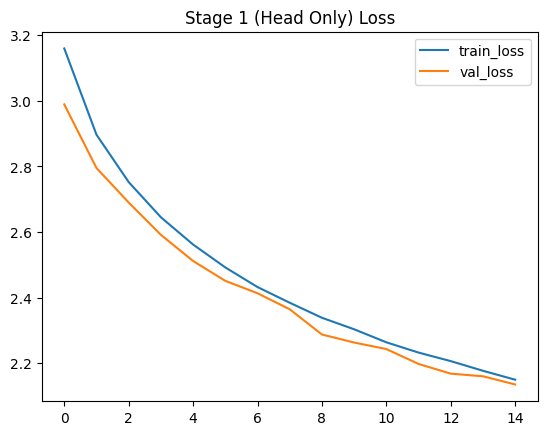

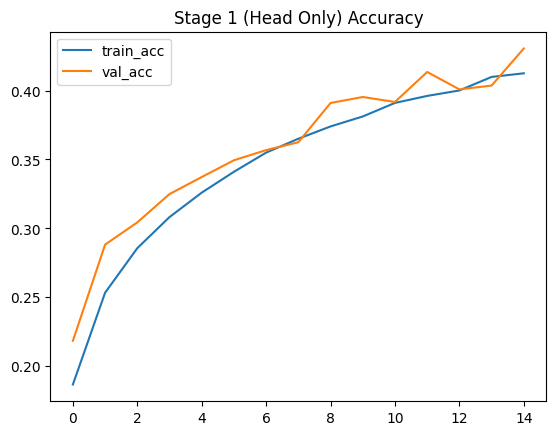

In [8]:
# ══ 8) Plot & Print Stage-1 Metrics ═════════════════════════════════════════
def plot_history(hist, stage):
    plt.figure()
    plt.plot(hist.history['loss'], label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.title(f'{stage} Loss'); plt.legend()
    plt.figure()
    plt.plot(hist.history['accuracy'], label='train_acc')
    plt.plot(hist.history['val_accuracy'], label='val_acc')
    plt.title(f'{stage} Accuracy'); plt.legend()

plot_history(history1, 'Stage 1 (Head Only)')
train_acc1 = history1.history['accuracy'][-1]
val_acc1   = history1.history['val_accuracy'][-1]
print(f"Stage 1 final Train Accuracy: {train_acc1:.4f}, Validation Accuracy: {val_acc1:.4f}")

In [9]:
# ══ 9) Stage-2: Fine-Tuning (Resumeable) ═══════════════════════════════════
for layer in base_model.layers[-30:]:
    layer.trainable = True
model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
fine_name = 'resnet50_finetuned'
mp2, hp2, e1 = find_last_checkpoint(SAVE_DIR, fine_name)
if mp2:
    print(f"Resuming fine-tuning from epoch {e1}")
    model.load_weights(mp2)
    initial_ft = e1
else:
    print("Starting fine-tuning from scratch")
    initial_ft = 0
cb_ft = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7),
    EpochCheckpoint(SAVE_DIR, fine_name)
]
history2 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=initial_ft + NUM_FINE_TUNE_EPOCHS,
    initial_epoch=initial_ft,
    callbacks=cb_ft
)
print(f"Fine-tuning complete. Latest checkpoint: {fine_name}_{initial_ft+NUM_FINE_TUNE_EPOCHS:02d}.h5")


Starting fine-tuning from scratch
Epoch 1/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.3956 - loss: 8.9015

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 678s 485ms/step - accuracy: 0.3957 - loss: 8.8972 - val_accuracy: 0.5907 - val_loss: 1.3961 - learning_rate: 1.0000e-05
Epoch 2/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.5933 - loss: 1.3716

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 655s 483ms/step - accuracy: 0.5933 - loss: 1.3716 - val_accuracy: 0.6125 - val_loss: 1.3335 - learning_rate: 1.0000e-05
Epoch 3/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.6345 - loss: 1.2186

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 655s 482ms/step - accuracy: 0.6345 - loss: 1.2186 - val_accuracy: 0.6569 - val_loss: 1.1150 - learning_rate: 1.0000e-05
Epoch 4/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.6701 - loss: 1.0821

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 656s 483ms/step - accuracy: 0.6701 - loss: 1.0821 - val_accuracy: 0.6393 - val_loss: 1.2063 - learning_rate: 1.0000e-05
Epoch 5/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.6919 - loss: 1.0040

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 652s 480ms/step - accuracy: 0.6919 - loss: 1.0040 - val_accuracy: 0.6177 - val_loss: 1.3073 - learning_rate: 1.0000e-05
Epoch 6/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.7379 - loss: 0.8418

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 658s 485ms/step - accuracy: 0.7379 - loss: 0.8418 - val_accuracy: 0.7394 - val_loss: 0.8392 - learning_rate: 5.0000e-06
Epoch 7/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.7563 - loss: 0.7714

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 659s 485ms/step - accuracy: 0.7563 - loss: 0.7714 - val_accuracy: 0.7595 - val_loss: 0.7738 - learning_rate: 5.0000e-06
Epoch 8/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.7675 - loss: 0.7424

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 659s 486ms/step - accuracy: 0.7675 - loss: 0.7424 - val_accuracy: 0.7568 - val_loss: 0.7773 - learning_rate: 5.0000e-06
Epoch 9/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.7728 - loss: 0.7230

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 658s 485ms/step - accuracy: 0.7728 - loss: 0.7230 - val_accuracy: 0.7574 - val_loss: 0.8002 - learning_rate: 5.0000e-06
Epoch 10/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.7959 - loss: 0.6464

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 662s 487ms/step - accuracy: 0.7959 - loss: 0.6464 - val_accuracy: 0.7667 - val_loss: 0.7401 - learning_rate: 2.5000e-06
Epoch 11/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8063 - loss: 0.6070

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 657s 484ms/step - accuracy: 0.8063 - loss: 0.6070 - val_accuracy: 0.7989 - val_loss: 0.6375 - learning_rate: 2.5000e-06
Epoch 12/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.8102 - loss: 0.5985

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 656s 483ms/step - accuracy: 0.8102 - loss: 0.5985 - val_accuracy: 0.7989 - val_loss: 0.6349 - learning_rate: 2.5000e-06
Epoch 13/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8140 - loss: 0.5856

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 652s 480ms/step - accuracy: 0.8140 - loss: 0.5856 - val_accuracy: 0.8058 - val_loss: 0.6186 - learning_rate: 2.5000e-06
Epoch 14/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8176 - loss: 0.5686

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 651s 479ms/step - accuracy: 0.8176 - loss: 0.5686 - val_accuracy: 0.7999 - val_loss: 0.6201 - learning_rate: 2.5000e-06
Epoch 15/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8172 - loss: 0.5662

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 653s 481ms/step - accuracy: 0.8172 - loss: 0.5662 - val_accuracy: 0.8169 - val_loss: 0.5816 - learning_rate: 2.5000e-06
Epoch 16/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8275 - loss: 0.5394

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 652s 480ms/step - accuracy: 0.8275 - loss: 0.5394 - val_accuracy: 0.7736 - val_loss: 0.7116 - learning_rate: 2.5000e-06
Epoch 17/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8259 - loss: 0.5409

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 650s 478ms/step - accuracy: 0.8259 - loss: 0.5409 - val_accuracy: 0.8070 - val_loss: 0.6125 - learning_rate: 2.5000e-06
Epoch 18/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8348 - loss: 0.5097

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 650s 479ms/step - accuracy: 0.8348 - loss: 0.5097 - val_accuracy: 0.8288 - val_loss: 0.5264 - learning_rate: 1.2500e-06
Epoch 19/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8390 - loss: 0.4943

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 650s 478ms/step - accuracy: 0.8390 - loss: 0.4943 - val_accuracy: 0.8419 - val_loss: 0.4905 - learning_rate: 1.2500e-06
Epoch 20/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8448 - loss: 0.4855

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 655s 482ms/step - accuracy: 0.8448 - loss: 0.4855 - val_accuracy: 0.8453 - val_loss: 0.4899 - learning_rate: 1.2500e-06
Epoch 21/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8457 - loss: 0.4751

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 658s 485ms/step - accuracy: 0.8457 - loss: 0.4751 - val_accuracy: 0.8433 - val_loss: 0.4897 - learning_rate: 1.2500e-06
Epoch 22/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8490 - loss: 0.4674

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 650s 478ms/step - accuracy: 0.8490 - loss: 0.4674 - val_accuracy: 0.8428 - val_loss: 0.4904 - learning_rate: 1.2500e-06
Epoch 23/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8483 - loss: 0.4731

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 651s 479ms/step - accuracy: 0.8483 - loss: 0.4731 - val_accuracy: 0.8426 - val_loss: 0.4803 - learning_rate: 1.2500e-06
Epoch 24/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.8526 - loss: 0.4564

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 654s 482ms/step - accuracy: 0.8526 - loss: 0.4564 - val_accuracy: 0.8392 - val_loss: 0.5040 - learning_rate: 1.2500e-06
Epoch 25/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8502 - loss: 0.4607

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 667s 491ms/step - accuracy: 0.8502 - loss: 0.4607 - val_accuracy: 0.8463 - val_loss: 0.4689 - learning_rate: 1.2500e-06
Epoch 26/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8512 - loss: 0.4620

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 651s 480ms/step - accuracy: 0.8512 - loss: 0.4620 - val_accuracy: 0.8496 - val_loss: 0.4619 - learning_rate: 1.2500e-06
Epoch 27/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8542 - loss: 0.4505

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 651s 480ms/step - accuracy: 0.8542 - loss: 0.4505 - val_accuracy: 0.8422 - val_loss: 0.4843 - learning_rate: 1.2500e-06
Epoch 28/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8554 - loss: 0.4537

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 652s 480ms/step - accuracy: 0.8554 - loss: 0.4537 - val_accuracy: 0.8516 - val_loss: 0.4605 - learning_rate: 1.2500e-06
Epoch 29/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.8571 - loss: 0.4390

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 653s 481ms/step - accuracy: 0.8571 - loss: 0.4390 - val_accuracy: 0.8469 - val_loss: 0.4739 - learning_rate: 1.2500e-06
Epoch 30/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8609 - loss: 0.4345

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 653s 481ms/step - accuracy: 0.8609 - loss: 0.4345 - val_accuracy: 0.8562 - val_loss: 0.4465 - learning_rate: 1.2500e-06
Epoch 31/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.8566 - loss: 0.4411

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 655s 482ms/step - accuracy: 0.8566 - loss: 0.4411 - val_accuracy: 0.8576 - val_loss: 0.4481 - learning_rate: 1.2500e-06
Epoch 32/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8601 - loss: 0.4327

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 657s 484ms/step - accuracy: 0.8601 - loss: 0.4327 - val_accuracy: 0.8518 - val_loss: 0.4612 - learning_rate: 1.2500e-06
Epoch 33/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8633 - loss: 0.4258

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 651s 480ms/step - accuracy: 0.8633 - loss: 0.4258 - val_accuracy: 0.8670 - val_loss: 0.4152 - learning_rate: 6.2500e-07
Epoch 34/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8629 - loss: 0.4225

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 651s 480ms/step - accuracy: 0.8629 - loss: 0.4225 - val_accuracy: 0.8602 - val_loss: 0.4311 - learning_rate: 6.2500e-07
Epoch 35/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8673 - loss: 0.4043

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 652s 480ms/step - accuracy: 0.8673 - loss: 0.4043 - val_accuracy: 0.8642 - val_loss: 0.4256 - learning_rate: 6.2500e-07
Epoch 36/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8720 - loss: 0.4070

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 657s 484ms/step - accuracy: 0.8720 - loss: 0.4070 - val_accuracy: 0.8675 - val_loss: 0.4104 - learning_rate: 3.1250e-07
Epoch 37/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8733 - loss: 0.3967

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 652s 480ms/step - accuracy: 0.8733 - loss: 0.3967 - val_accuracy: 0.8687 - val_loss: 0.4094 - learning_rate: 3.1250e-07
Epoch 38/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8716 - loss: 0.3960

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 654s 482ms/step - accuracy: 0.8716 - loss: 0.3960 - val_accuracy: 0.8675 - val_loss: 0.4163 - learning_rate: 3.1250e-07
Epoch 39/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.8714 - loss: 0.3980

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 655s 482ms/step - accuracy: 0.8714 - loss: 0.3980 - val_accuracy: 0.8663 - val_loss: 0.4115 - learning_rate: 3.1250e-07
Epoch 40/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8724 - loss: 0.3931

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 657s 484ms/step - accuracy: 0.8724 - loss: 0.3931 - val_accuracy: 0.8707 - val_loss: 0.3972 - learning_rate: 1.5625e-07
Epoch 41/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8727 - loss: 0.3948

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 652s 480ms/step - accuracy: 0.8727 - loss: 0.3948 - val_accuracy: 0.8736 - val_loss: 0.3810 - learning_rate: 1.5625e-07
Epoch 42/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8777 - loss: 0.3833

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 658s 485ms/step - accuracy: 0.8777 - loss: 0.3833 - val_accuracy: 0.8706 - val_loss: 0.3938 - learning_rate: 1.5625e-07
Epoch 43/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8764 - loss: 0.3849

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 657s 484ms/step - accuracy: 0.8764 - loss: 0.3849 - val_accuracy: 0.8733 - val_loss: 0.3985 - learning_rate: 1.5625e-07
Epoch 44/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.8750 - loss: 0.3815

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 655s 482ms/step - accuracy: 0.8750 - loss: 0.3815 - val_accuracy: 0.8687 - val_loss: 0.3966 - learning_rate: 1.0000e-07
Fine-tuning complete. Latest checkpoint: resnet50_finetuned_100.h5


Stage 2 final Train Accuracy: 0.8733, Validation Accuracy: 0.8687


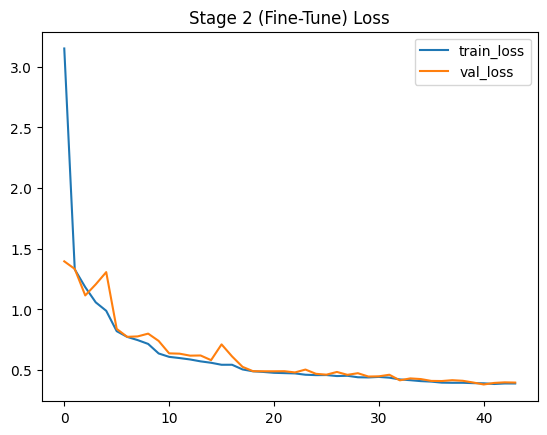

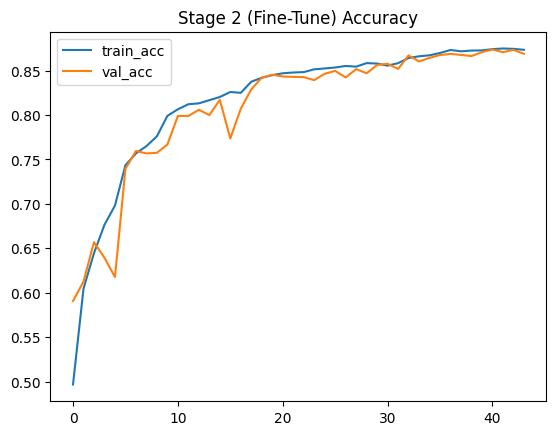

In [10]:
# ══ 10) Plot & Print Stage-2 Metrics ═════════════════════════════════════════
plot_history(history2, 'Stage 2 (Fine-Tune)')
train_acc2 = history2.history['accuracy'][-1]
val_acc2   = history2.history['val_accuracy'][-1]
print(f"Stage 2 final Train Accuracy: {train_acc2:.4f}, Validation Accuracy: {val_acc2:.4f}")


In [11]:
val_loss, val_acc = model.evaluate(val_ds, verbose=1)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


340/340 ━━━━━━━━━━━━━━━━━━━━ 131s 386ms/step - accuracy: 0.8675 - loss: 0.4110
Validation Loss: 0.3932, Validation Accuracy: 0.8746
